## Hackathon

In [51]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

xr.set_options(display_style="text")

## Data loader om data uit de grote set te halen.

Gebruik `loader.get_subset()` voor specifieke ranges van tijd, longitude en latitude. 

Gebruik `subset.to_dataframe()` om een tabel van type xarray om te zetten naar een pandas dataframe. 

In [5]:
class DataLoader:
    """Simple dataloader for NetCDF temperature data."""
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.dataset = None
    
    def load_data(self):
        """Load and preprocess the dataset."""
        self.dataset = xr.open_dataset(self.file_path, engine="h5netcdf")
        
        # Fix coordinates
        if self.dataset["longitude"].max() > 180:
            self.dataset = self.dataset.assign_coords(
                longitude=(self.dataset["longitude"].values + 180) % 360 - 180
            )
        if self.dataset["latitude"].max() > 90:
            self.dataset = self.dataset.assign_coords(
                latitude=self.dataset["latitude"].values - 90
            )
        
        # Sort coordinates
        self.dataset = self.dataset.sortby(["latitude", "longitude"])
        return self.dataset
    
    def get_subset(self, time_range=None, lat_range=None, lon_range=None):
        """Get a subset of the data."""
        if self.dataset is None:
            raise ValueError("Load data first!")
        
        subset = self.dataset
        if time_range:
            subset = subset.sel(valid_time=slice(time_range[0], time_range[1]))
        if lat_range:
            subset = subset.sel(latitude=slice(lat_range[0], lat_range[1]))
        if lon_range:
            subset = subset.sel(longitude=slice(lon_range[0], lon_range[1]))
        
        return subset.compute()
    


In [6]:
# Example usage
loader = DataLoader("2023_2m_temperature.nc")
dataset = loader.load_data()

In [7]:
print(dataset['longitude'].min().item())
print(dataset['longitude'].max().item())
print(dataset['latitude'].min().item())
print(dataset['latitude'].max().item())

-25.0
37.25
34.0
71.25


In [8]:
# Get a subset (May 2023, Europe)
subset = loader.get_subset(
    time_range=("2023-05-01", "2023-05-31"),
    lat_range=(52.25, 52.25),
    lon_range=(5.0, 5.0)
)
subset

<xarray.Dataset> Size: 21kB
Dimensions:     (valid_time: 744, latitude: 1, longitude: 1)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 6kB 2023-05-01 ... 2023-05-31T23:...
  * latitude    (latitude) float64 8B 52.25
  * longitude   (longitude) float64 8B 5.0
    expver      (valid_time) <U4 12kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    t2m         (valid_time, latitude, longitude) float32 3kB 282.2 ... 284.2
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-19T08:59 GRIB to CDM+CF via cfgrib-0.9.1...

In [9]:
subset["t2m"].data.flatten()[0:10]

array([282.20166, 281.77856, 281.55127, 281.06763, 280.6704 , 281.2251 ,
       282.7295 , 284.03662, 285.3191 , 286.8589 ], dtype=float32)

In [10]:
subset.to_dataframe()

,,,number,expver,t2m
valid_time,latitude,longitude,,,
2023-05-01 00:00:00,52.25,5.0,0,0001,282.201660
2023-05-01 01:00:00,52.25,5.0,0,0001,281.778564
2023-05-01 02:00:00,52.25,5.0,0,0001,281.551270
2023-05-01 03:00:00,52.25,5.0,0,0001,281.067627
2023-05-01 04:00:00,52.25,5.0,0,0001,280.670410
...,...,...,...,...,...
2023-05-31 19:00:00,52.25,5.0,0,0001,288.152588
2023-05-31 20:00:00,52.25,5.0,0,0001,286.337646
2023-05-31 21:00:00,52.25,5.0,0,0001,285.362793


## Methode om je forecast functie te evalueren op een random steekproef van de dataset. 
In dit voorbeeld wordt steeds 2 weken historische data gepakt en wordt 1 week vooruit voorspeld.

`generate_eval_data()` geeft n random periodes van 3 weken op willekeurige locaties.

`forecast(history, n_points)` neemt een historische reeks van temperaturen en voorspelt de volgende n_points.

`forecast_1w()` evalueert de forecast functie op een random week (MAE score) en toont een grafiek van de historische reeks, de echte waardes en de voorspelde waarde. 

`evaluator(function, n_samples)` berekent de mean absolute error (MAE) van de voorspelling van functie `forecast()` voor een steekproef van grootte n_samples. 

In [11]:
def generate_eval_data(n = 100):
    rng = np.random.default_rng()
    
    # ---- Random geolocation ----
    # Longitude uniform in [-180, 180)
    lon = rng.uniform(-25, 37.25, n)
    lon = np.round(lon * 4)/4
    
    # Latitude area-uniform: sample z = sin(lat) ~ U(-1,1)  => lat = arcsin(z)
    lat = rng.uniform(34, 71.25, n)
    lat = np.round(lat * 4)/4
    
    # ---- Random 3-week interval in 2023 ----
    start0 = pd.Timestamp("2023-01-01")
    # Inclusive end = start + 20 days (21 calendar days total)
    last_start = pd.Timestamp("2023-12-31") - pd.Timedelta(days=20)
    num_choices = (last_start - start0).days + 1
    
    offsets = rng.integers(0, num_choices, n)  # days after Jan 1
    start_date = start0 + pd.to_timedelta(offsets, unit="D")
    end_date = start_date + pd.Timedelta(days=20)
    
    # ---- Assemble DataFrame ----
    df = pd.DataFrame({
        "latitude_deg": lat,
        "longitude_deg": lon,
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d")
    })
    return df

In [12]:
generate_eval_data(5)

,latitude_deg,longitude_deg,start_date,end_date
0,34.25,21.00,2023-11-20,2023-12-10
1,43.00,33.50,2023-05-01,2023-05-21
2,45.75,15.50,2023-03-02,2023-03-22
3,40.50,25.50,2023-07-01,2023-07-21
4,55.00,7.25,2023-11-14,2023-12-04


In [13]:
def forecast(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):
    # Take the last point of the history and repeat it n_points times
    try:
        return np.full(n_points, history[-1])
    except: 
        return np.full(n_points, 0)

def forecast_1w(row, function, operation = 'loop'):
    sample = loader.get_subset(
            time_range=(row['start_date'], row['end_date']),
            lat_range=(row['latitude_deg'], row['latitude_deg']),
            lon_range=(row['longitude_deg'], row['longitude_deg'])
        ).compute()
    history = sample.sel(valid_time=slice(row['start_date'],(pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d")))['t2m'].data.flatten()
    y_true = sample.sel(valid_time=slice((pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"),row['end_date']))['t2m'].data.flatten()
    y_pred = function(history, 
                      row['longitude_deg'], 
                      row['latitude_deg'], 
                      row['start_date'],
                      (pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"), 
                      len(y_true))
    if operation == 'manual':
        fig, ax = plt.subplots()
        ax.plot(range(len(history)), history, color = 'blue')
        ax.plot(range(len(history), len(history) + len(y_true)), y_true, color = 'blue', linestyle = 'dashed')
        ax.plot(range(len(history), len(history) + len(y_true)), y_pred, color = 'green', linestyle = (0, (1, 1)))
    return np.mean(np.abs(y_true - y_pred))

In [14]:
forecast(np.array([9,8,18]), n_points = 5)

array([18, 18, 18, 18, 18])

np.float32(1.8169558)

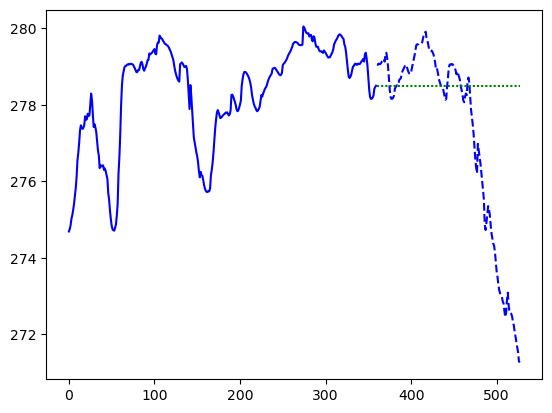

In [26]:
forecast_1w(generate_eval_data(1).iloc[0], forecast, 'manual')

In [18]:
def evaluator(function, n_samples = 100):
    errors = []
    df = generate_eval_data(n_samples)
    for index, row in df.iterrows():
        error = forecast_1w(row, function, operation = 'loop')
        errors.append(error)
    return np.mean(errors)

In [21]:
evaluator(forecast, 10)

np.float32(3.3239155)

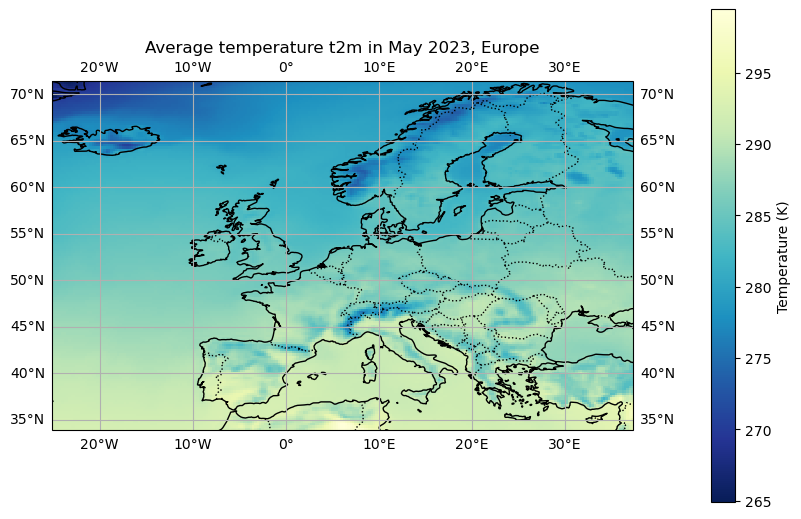

In [74]:
# Task 1
lats = np.linspace(34, 71.25, 150)
lons = np.linspace(-25, 37.25, 250)

LON, LAT = np.meshgrid(lons, lats)

t2m_values = loader.get_subset(
    time_range=("2023-05-01", "2023-05-31"),
    lat_range=(34, 71.25),
    lon_range=(-25, 37.25)
)

monthly_mean = t2m_values['t2m'].mean(dim='valid_time').values

coords = np.stack([LAT, LON], axis=-1)

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

pcm = ax.pcolormesh(
    LON, LAT, monthly_mean,
    cmap='YlGnBu_r',
    shading='auto'
)

# Add country borders
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.1, shrink=0.8)
cbar.set_label('Temperature (K)')

ax.set_title('Average temperature t2m in May 2023, Europe')
plt.show()
